In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

import lsst.afw.geom as afwGeom

#import lsst.ip.diffim as ipDiffim
# I linked from ip_diffim/python/lsst/ip/diffim/imageMapReduce.py into diffimTests/imageMapReduce.py
#    (or copy it)

In [2]:
import diffimTests as dit
#reload(dit)

testObj = dit.DiffimTest(varFlux2=np.repeat(2000, 20), #620*np.sqrt(2), 10),
                         n_sources=600, verbose=True, sourceFluxRange=(2000., 120000.), 
                         psf_yvary_factor=0.5, psfSize=13)
res = testObj.runTest(spatialKernelOrder=2)
print res

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: -0.492813481453 0.493450410102
Variable source: 11 481.504254729 446.769330925 0 2000
Variable source: 6 60.2485291279 35.3191743182 0 2000
Variable source: 19 441.050733817 436.806559587 0 2000
Variable source: 20 446.291646029 86.4683838602 0 2000
Variable source: 1 66.5809759253 424.38486369 0 2000
Variable source: 12 466.843050607 342.354052063 0 2000
Variable source: 17 45.6530981449 331.260325215 0 2000
Variable source: 10 302.643969883 44.7418294743 0 2000
Variable source: 0 368.142255845 436.045411845 0 2000
Variable source: 13 146.056622889 434.017042329 0 2000
Variable source: 5 396.07140698 121.296576813 0 2000
Variable source: 21 245.245586804 439.913841214 0 2000
Variable source: 24 129.950748293 390.033308509 0 2000
Variable source: 4 431.666157472 255.180259503 0 2000
Variable source: 8 277.951989376 82.2791446766 0 2000
Variable source: 22 233.327308185 

In [3]:
exposure = testObj.im2.asAfwExposure()
template = testObj.im1.asAfwExposure()

exposure.setPsf(testObj.variablePsf.getCoaddPsf(exposure))
exposure.getPsf().computeKernelImage(afwGeom.Point2D(28., 66.)).getDimensions()

Extent2I(27, 25)

A&L(dec): stats(mean=0.11608639, stdev=24.692617, min=-162.86592, max=252.57611)
Zogy: stats(mean=0.071210619923302285, stdev=24.933300437513545, min=-766.0879587769399, max=920.04163361969643)
A&L(dec) - Zogy: stats(mean=0.0080173586688510427, stdev=2.7184396848294159, min=-509.36853219687396, max=760.64012762307027)
A&L(dec) - A&L: stats(mean=-0.03347978, stdev=6.8337188, min=-45.460281, max=70.804291)
Scorr: stats(mean=3.9852536162070607e-06, stdev=0.00026903149992545258, min=-0.014586432067908918, max=0.013801033837541277)
Scorr_var: stats(mean=0.00025189556058477275, stdev=1.4065713554371549e-06, min=0.00024673748783295304, max=0.00095368022470683955)


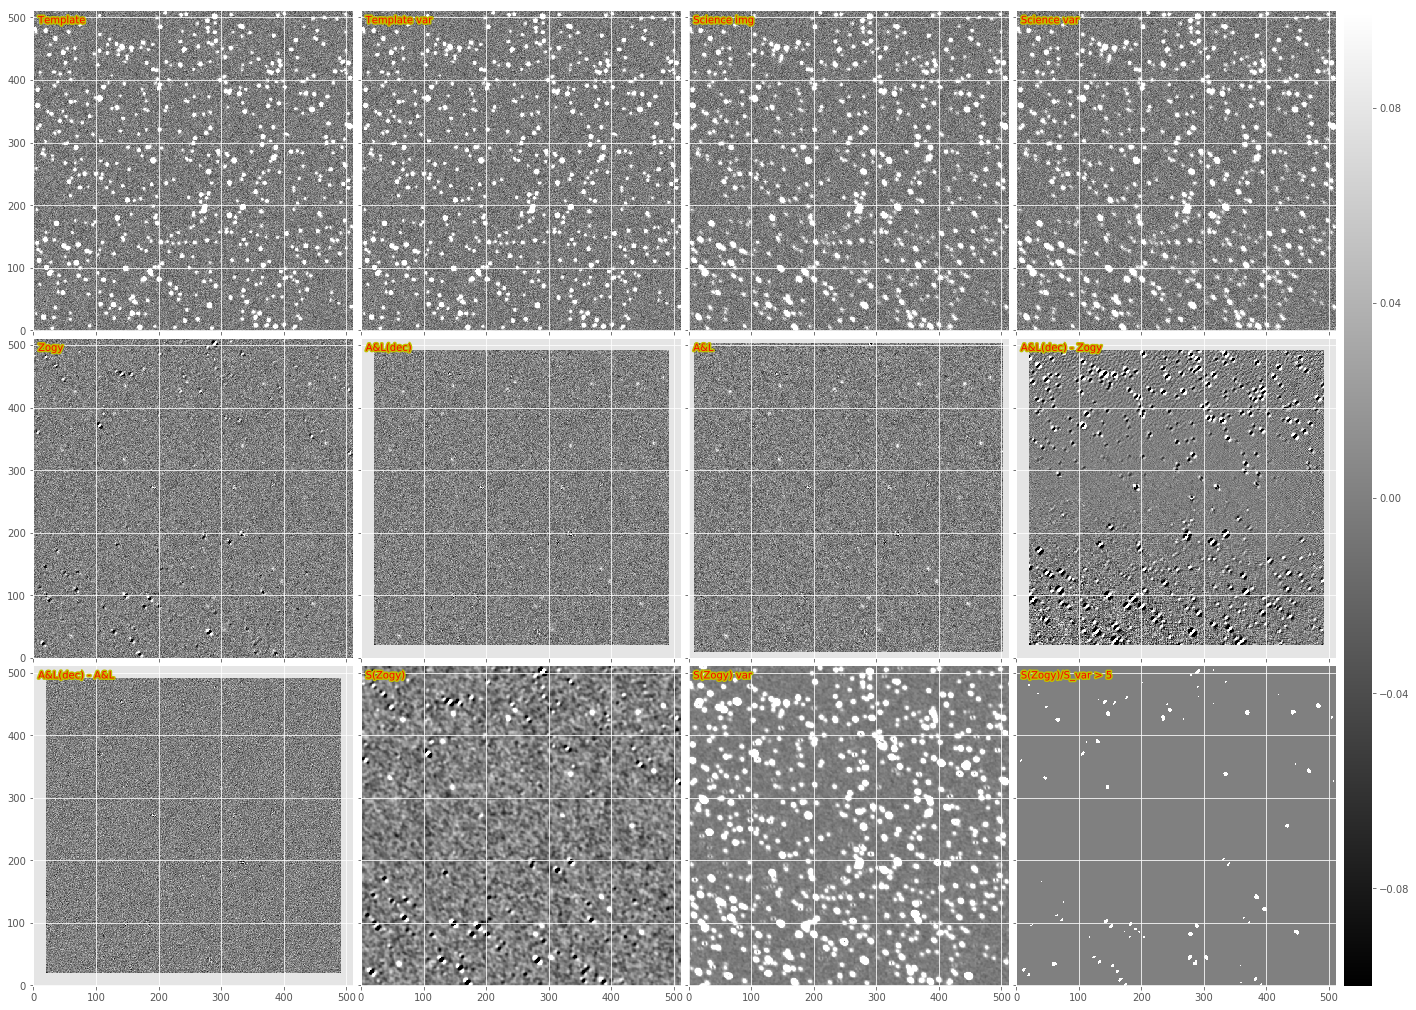

In [4]:
#dit.plotImageGrid((testObj.im1.im, testObj.im2.im), imScale=8)
testObj.doPlot(imScale=6, include_Szogy=True);

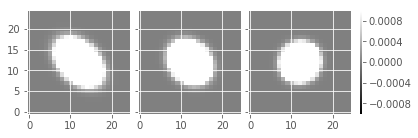

In [5]:
dit.plotImageGrid((testObj.variablePsf.getImage(20., 20.), 
                   testObj.variablePsf.getImage(250., 250.),
                   testObj.variablePsf.getImage(500., 500.)), clim=(-0.001, 0.001))

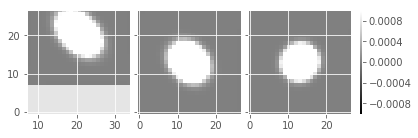

In [6]:
dit.plotImageGrid((exposure.getPsf().computeImage(afwGeom.Point2D(20., 20.)),
                   exposure.getPsf().computeImage(afwGeom.Point2D(250., 250.)),
                   exposure.getPsf().computeImage(afwGeom.Point2D(500., 500.)),), clim=(-0.001, 0.001))

OK, let's try a spatially-varying A&L Decorrelation!

But without correctly setting the (spatially varying) PSF of the diffim.

In [104]:
import lsst.pex.config as pexConfig
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.pipe.base as pipeBase
import lsst.ip.diffim as ipDiffim

class ALdecMapperSubtask(dit.ImageMapperSubtask):
    ConfigClass = dit.ImageMapperSubtaskConfig
    _DefaultName = 'diffimTests_ALdecMapperSubtask'
    
    def __init__(self, *args, **kwargs):
        dit.ImageMapperSubtask.__init__(self, *args, **kwargs)
        
    def run(self, subExp, expandedSubExp, fullBBox, **kwargs):
        bbox = subExp.getBBox()
        center = ((bbox.getBeginX() + bbox.getEndX()) // 2., (bbox.getBeginY() + bbox.getEndY()) // 2.)
        center = afwGeom.Point2D(center[0], center[1])
        
        variablePsf2 = kwargs.get('variablePsf', None)
        sigmaSquared = kwargs.get('sigmaSquared', None)
        alTaskResult = kwargs.get('alTaskResult', None)
        im1 = kwargs.get('template', None)  # im1 = input template
        im2 = kwargs.get('science', None)   # im2 = input science image
        preConvKernel = kwargs.get('preConvKernel', None)
                
        # subExp and expandedSubExp are subimages of the (decorrelated) diffim!
        
        subExp2 = afwImage.ExposureF(im2, expandedSubExp.getBBox())
        subim2 = expandedSubExp.getMaskedImage()
        if sigmaSquared is None:
            subvar2 = subim2.getVariance().getArray()
            sig2squared = dit.computeClippedImageStats(subvar2).mean
        else:
            sig2squared = sigmaSquared[1]  # for testing, can use the input sigma (global value for entire exposure)
        
        # Psf and image for template img (index 1)
        subExp1 = afwImage.ExposureF(im1, expandedSubExp.getBBox())
        subim1 = subExp1.getMaskedImage()
        if sigmaSquared is None:
            subvar1 = subim1.getVariance().getArray()
            sig1squared = dit.computeClippedImageStats(subvar1).mean
        else:
            sig1squared = sigmaSquared[0]

        # This code taken more-or-less directly from dit.tasks.doALdecorrelation:
        kimg = dit.afw.alPsfMatchingKernelToArray(alTaskResult.psfMatchingKernel, coord=center)
        dck = dit.decorrelation.computeDecorrelationKernel(kimg, sig1squared, sig2squared,
                                                     preConvKernel=preConvKernel, delta=0.)
        diffim, _ = dit.afw.doConvolve(expandedSubExp, dck, use_scipy=False)
        img = diffim.getMaskedImage().getImage().getArray()
        img[~np.isfinite(img)] = np.nan
        img = diffim.getMaskedImage().getVariance().getArray()
        img[~np.isfinite(img)] = np.nan
        
        if variablePsf2 is None:
            #psf = dit.afw.afwPsfToArray(alTaskResult.subtractedExposure.getPsf(), coord=center)
            psf = dit.afw.afwPsfToArray(im2.getPsf(), coord=center)
            if psf.shape[0] < psf.shape[1]:  # sometimes CoaddPsf does this.
                psf = np.pad(psf, ((1, 1), (0, 0)), mode='constant')
            elif psf.shape[0] > psf.shape[1]:
                psf = np.pad(psf, ((0, 0), (1, 1)), mode='constant')
            #psf = dit.afw.afwPsfToArray(exposure.getPsf(), coord=center)
            #print 'HERE:', center, dit.afw.arrayToAfwPsf(psf).computeShape().getDeterminantRadius()
        else:
            psf = variablePsf2.getImage(center.getX(), center.getY())
        #print center, dit.afw.arrayToAfwPsf(psf).computeShape().getDeterminantRadius(), psf.shape

        # NOTE! Need to compute the updated PSF including preConvKernel !!! This doesn't do it:
        psfc = dit.decorrelation.computeCorrectedDiffimPsf(kimg, psf, tvar=sig1squared, svar=sig2squared)
        psfcI = afwImage.ImageD(psfc.shape[0], psfc.shape[1])
        psfcI.getArray()[:, :] = psfc
        psfcK = afwMath.FixedKernel(psfcI)
        psfNew = measAlg.KernelPsf(psfcK)
        out = afwImage.ExposureF(diffim, subExp.getBBox())
        out.setPsf(psfNew)
                
        return pipeBase.Struct(subExposure=out, decorrelationKernel=dck, psf=psfNew)

class ALdecMapReduceConfig(dit.ImageMapReduceConfig):
    mapperSubtask = pexConfig.ConfigurableField(
        doc='A&L decorrelation subtask to run on each sub-image',
        target=ALdecMapperSubtask
    )

In [105]:
config = ALdecMapReduceConfig()
#config.gridStepX = config.gridStepY = 5
#config.gridSizeX = config.gridSizeY = 7
config.borderSizeX = config.borderSizeY = 3
config.reducerSubtask.reduceOperation = 'average'
task = dit.ImageMapReduceTask(config=config)
print config
#boxes0, boxes1 = task._generateGrid(exposure)

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


(27, 25)
(27, 27)


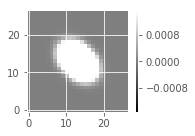

In [106]:
psf = exposure.getPsf().computeImage(afwGeom.Point2D(24, 66)).getArray()
print psf.shape
if psf.shape[0] < psf.shape[1]:  # sometimes CoaddPsf does this.
    psf = np.pad(psf, ((1, 1), (0, 0)), mode='constant')
elif psf.shape[0] > psf.shape[1]:
    psf = np.pad(psf, ((0, 0), (1, 1)), mode='constant')
print psf.shape
dit.plotImageGrid((psf,))

In [107]:
diffimOrig = testObj.ALres.subtractedExposure
newExp = task.run(diffimOrig, template=template, science=exposure,
                 alTaskResult=testObj.ALres, forceEvenSized=True).exposure

In [108]:
# Run with constant variance number to compare with single frame (non-gridded) ZOGY from above:
sig1 = dit.computeClippedImageStats(template.getMaskedImage().getVariance().getArray()).mean
sig2 = dit.computeClippedImageStats(exposure.getMaskedImage().getVariance().getArray()).mean
print sig1, sig2
newExpA = task.run(diffimOrig, template=template, science=exposure,
                 alTaskResult=testObj.ALres, sigmaSquared=[sig1, sig2], forceEvenSized=True).exposure

301.78 303.018


In [109]:
diffimOrig = testObj.ALres.subtractedExposure
newExpB = task.run(diffimOrig, template=template, science=exposure,
                  alTaskResult=testObj.ALres, forceEvenSized=True,
                  variablePsf=testObj.variablePsf).exposure

In [110]:
def ga(exposure):
    return exposure.getMaskedImage().getImage().getArray()
def gv(exposure):
    return exposure.getMaskedImage().getVariance().getArray()

stats(mean=3.0178895, stdev=19.085546, min=-71.0, max=4878.0)
stats(mean=0.11939853, stdev=24.175909, min=-161.21985, max=250.90202)
stats(mean=0.11892909, stdev=24.532379, min=-163.16049, max=253.50713)
stats(mean=0.11939853, stdev=24.175909, min=-161.21985, max=250.90202)
stats(mean=-0.031231677, stdev=6.3205862, min=-42.853516, max=64.936081)
stats(mean=-1.5752068e-10, stdev=3.7650054e-07, min=-7.6293945e-06, max=7.6293945e-06)
stats(mean=-0.033480298, stdev=6.6874161, min=-44.926651, max=68.887115)
stats(mean=-1.5752068e-10, stdev=3.7650054e-07, min=-7.6293945e-06, max=7.6293945e-06)


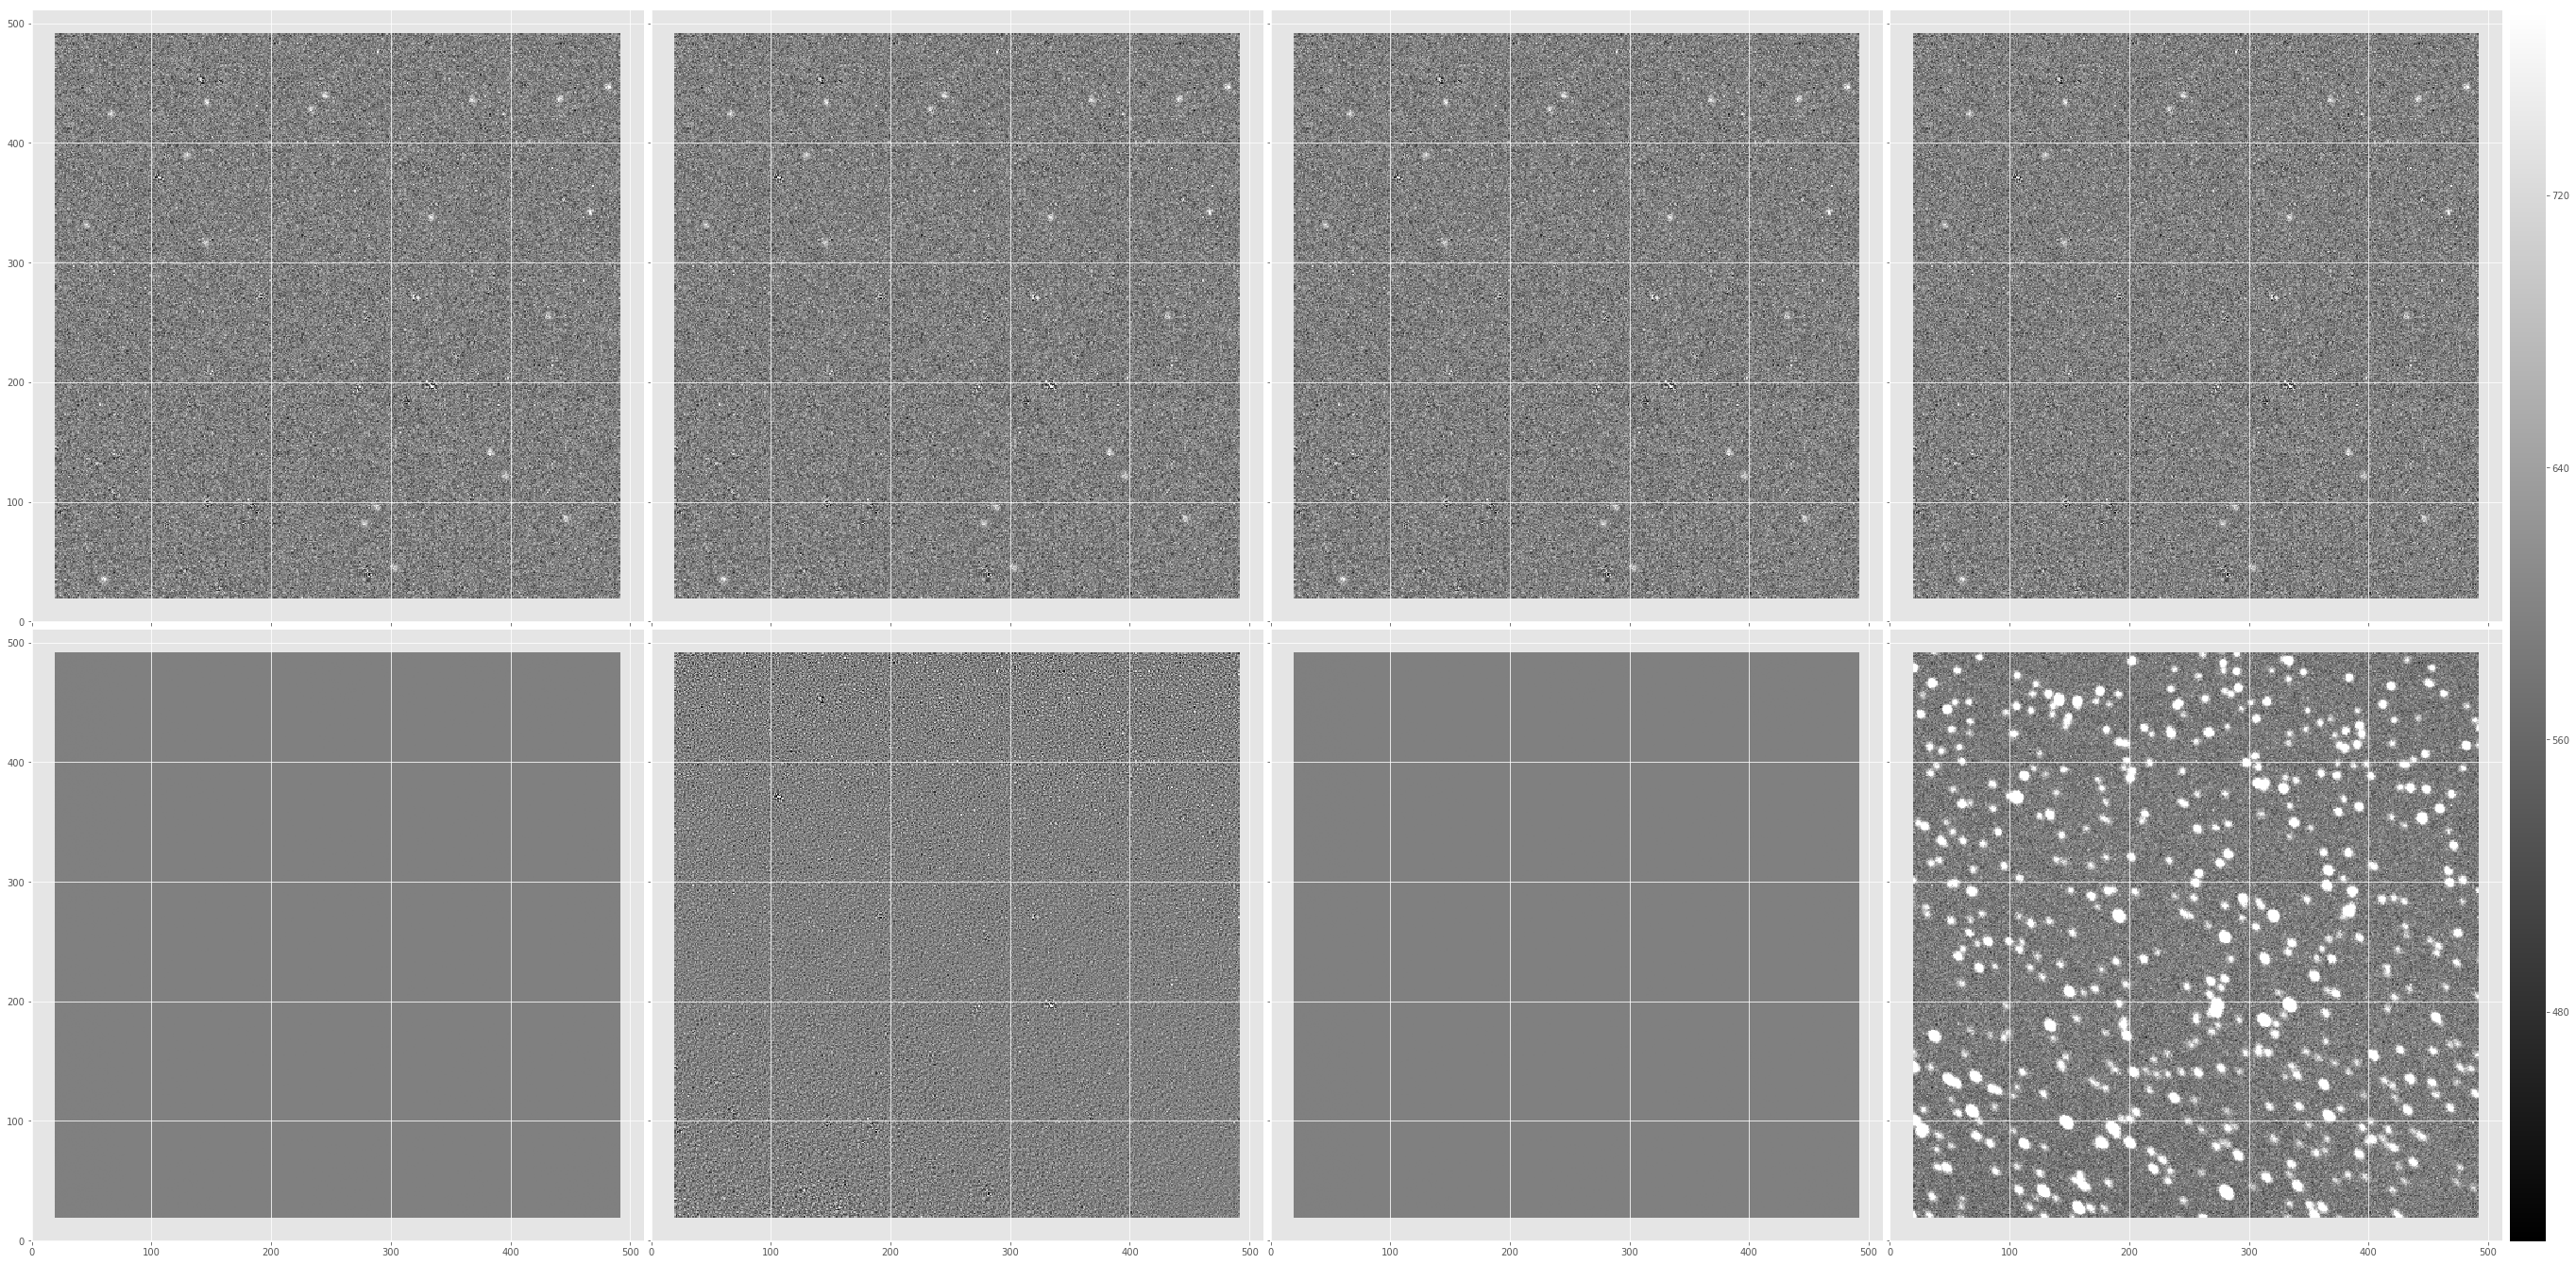

In [111]:
print dit.computeClippedImageStats(ga(exposure))
print dit.computeClippedImageStats(ga(newExp))
print dit.computeClippedImageStats(ga(newExpA))
print dit.computeClippedImageStats(ga(newExpB))
print dit.computeClippedImageStats(ga(newExp)-ga(testObj.ALres.subtractedExposure))
print dit.computeClippedImageStats(ga(newExp)-ga(testObj.ALres.decorrelatedDiffim))
print dit.computeClippedImageStats(ga(newExpA)-ga(testObj.ALres.subtractedExposure))
print dit.computeClippedImageStats(ga(newExpB)-ga(testObj.ALres.decorrelatedDiffim))
dit.plotImageGrid((ga(newExp), ga(newExpA), ga(newExpB), ga(testObj.ALres.decorrelatedDiffim), 
                   ga(newExp)-ga(testObj.ALres.decorrelatedDiffim),
                   ga(newExpA)-ga(testObj.ALres.decorrelatedDiffim), 
                   ga(newExpB)-ga(testObj.ALres.decorrelatedDiffim), gv(newExp)), imScale=12)

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


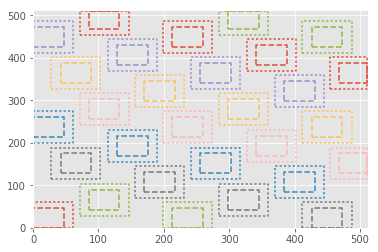

In [112]:
print task.config
task._plotBoxes(exposure.getBBox(), skip=5)

In [113]:
testObj.runTest(spatialKernelOrder=2)

{'ALstack': {'FN': 0, 'FP': 0, 'TP': 20},
 'ALstack_decorr': {'FN': 3, 'FP': 0, 'TP': 17},
 'SZogy': {'FN': 2, 'FP': 29, 'TP': 18},
 'Zogy': {'FN': 1, 'FP': 34, 'TP': 19}}

In [114]:
testObj2 = testObj.clone()
testObj2.ALres.decorrelatedDiffim = newExp
testObj2.runTest(spatialKernelOrder=2)

{'ALstack': {'FN': 0, 'FP': 0, 'TP': 20},
 'ALstack_decorr': {'FN': 3, 'FP': 0, 'TP': 17},
 'SZogy': {'FN': 2, 'FP': 29, 'TP': 18},
 'Zogy': {'FN': 1, 'FP': 34, 'TP': 19}}

In [115]:
testObj2 = testObj.clone()
testObj2.ALres.decorrelatedDiffim = newExpA
testObj2.runTest(spatialKernelOrder=2)

{'ALstack': {'FN': 0, 'FP': 0, 'TP': 20},
 'ALstack_decorr': {'FN': 1, 'FP': 0, 'TP': 19},
 'SZogy': {'FN': 2, 'FP': 29, 'TP': 18},
 'Zogy': {'FN': 1, 'FP': 34, 'TP': 19}}

In [116]:
testObj2 = testObj.clone()
testObj2.ALres.decorrelatedDiffim = newExpB
testObj2.runTest(spatialKernelOrder=2)

{'ALstack': {'FN': 0, 'FP': 0, 'TP': 20},
 'ALstack_decorr': {'FN': 3, 'FP': 0, 'TP': 17},
 'SZogy': {'FN': 2, 'FP': 29, 'TP': 18},
 'Zogy': {'FN': 1, 'FP': 34, 'TP': 19}}

Let's take a look at the decorrelation kernels and PSFs used on the various patches...

In [75]:
config = ALdecMapReduceConfig()
#config.gridStepX = config.gridStepY = 5
#config.gridSizeX = config.gridSizeY = 7
config.borderSizeX = config.borderSizeY = 3
config.reducerSubtask.reduceOperation = 'average'
task = dit.ImageMapReduceTask(config=config)
print config
#boxes0, boxes1 = task._generateGrid(exposure)

results = task._runMapper(diffimOrig, template=template, science=exposure,
                 alTaskResult=testObj.ALres, forceEvenSized=True) #, variablePsf=testObj.variablePsf)

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


In [76]:
def boxCenter(bbox):
    return ((bbox.getBeginX() + bbox.getEndX()) // 2., (bbox.getBeginY() + bbox.getEndY()) // 2.)

In [ ]:
centers = [boxCenter(res.subExposure.getBBox()) for res in results]
titles = ['%.0f,%.0f'%(c[0],c[1]) for c in centers]
subs = [res.subExposure for res in results]
dit.plotImageGrid(subs, titles=titles) #, clim=(-0.001,0.001))

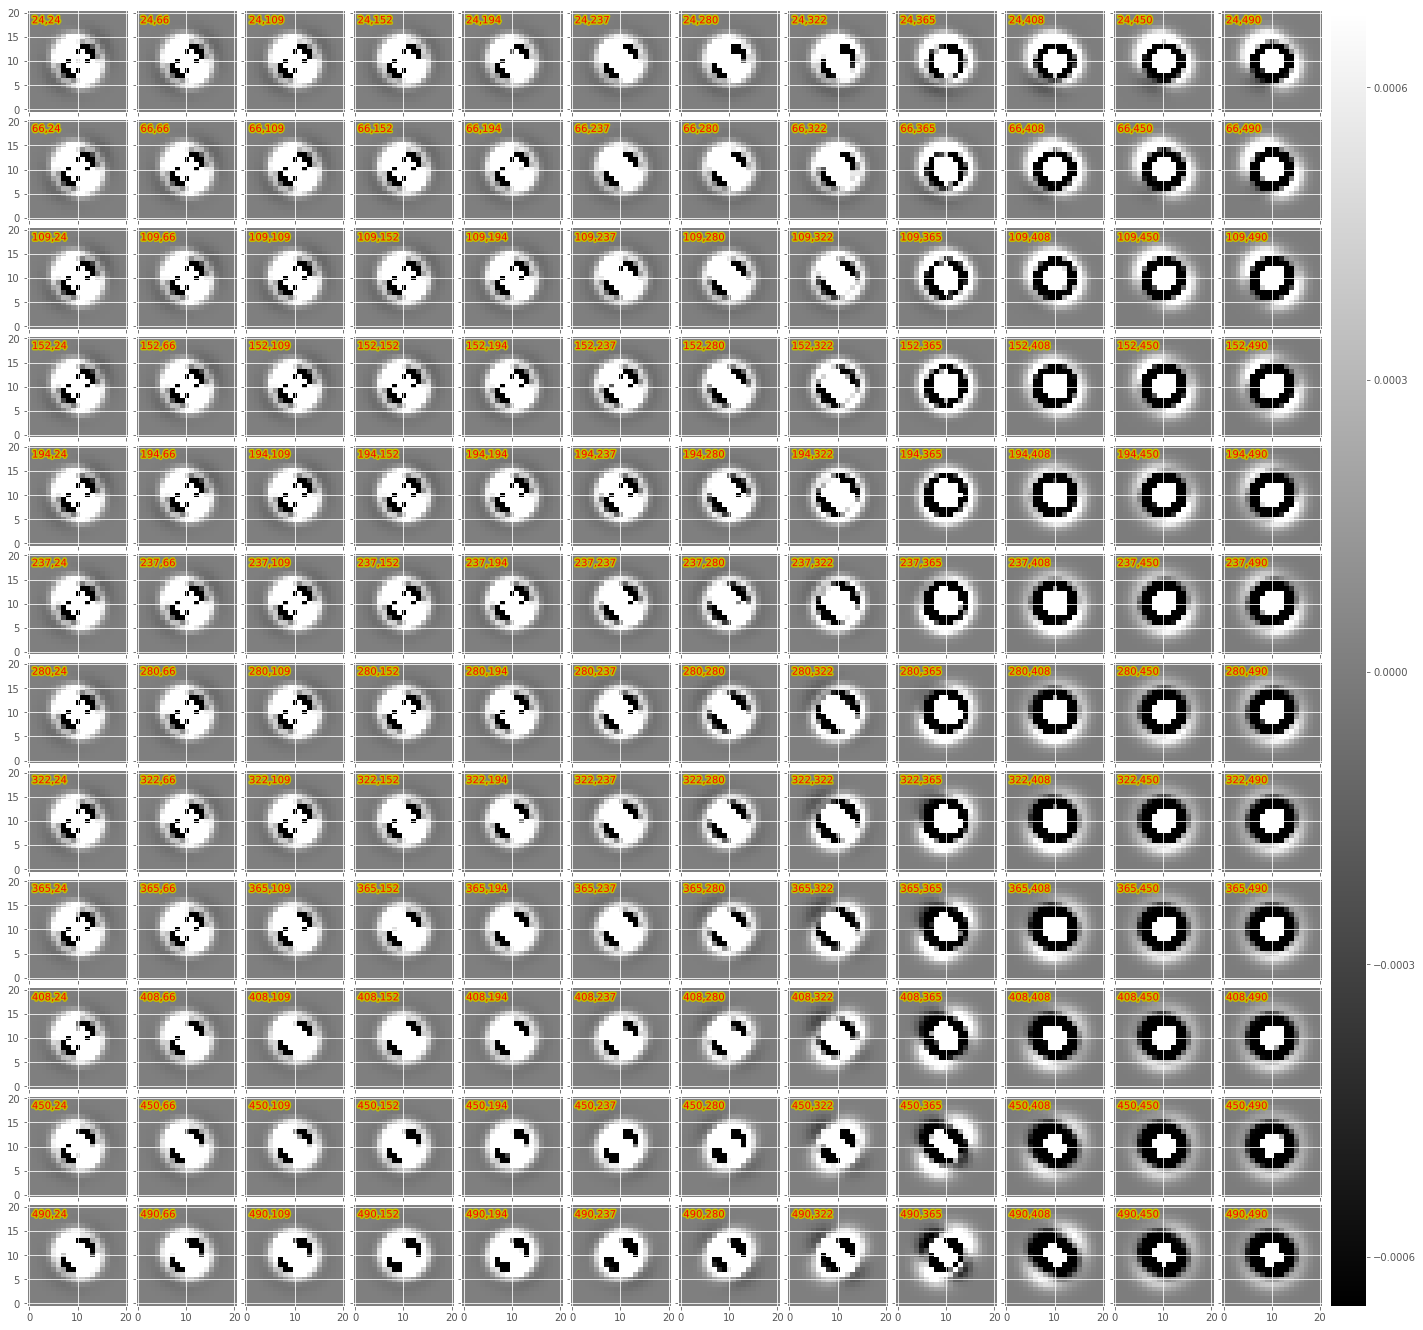

In [78]:
centers = [boxCenter(res.subExposure.getBBox()) for res in results]
kimgs = [dit.afw.alPsfMatchingKernelToArray(testObj2.ALres.psfMatchingKernel, coord=center) for center in centers]
titles = ['%.0f,%.0f' % (c[0], c[1]) for c in centers]
dit.plotImageGrid(kimgs, titles=titles)

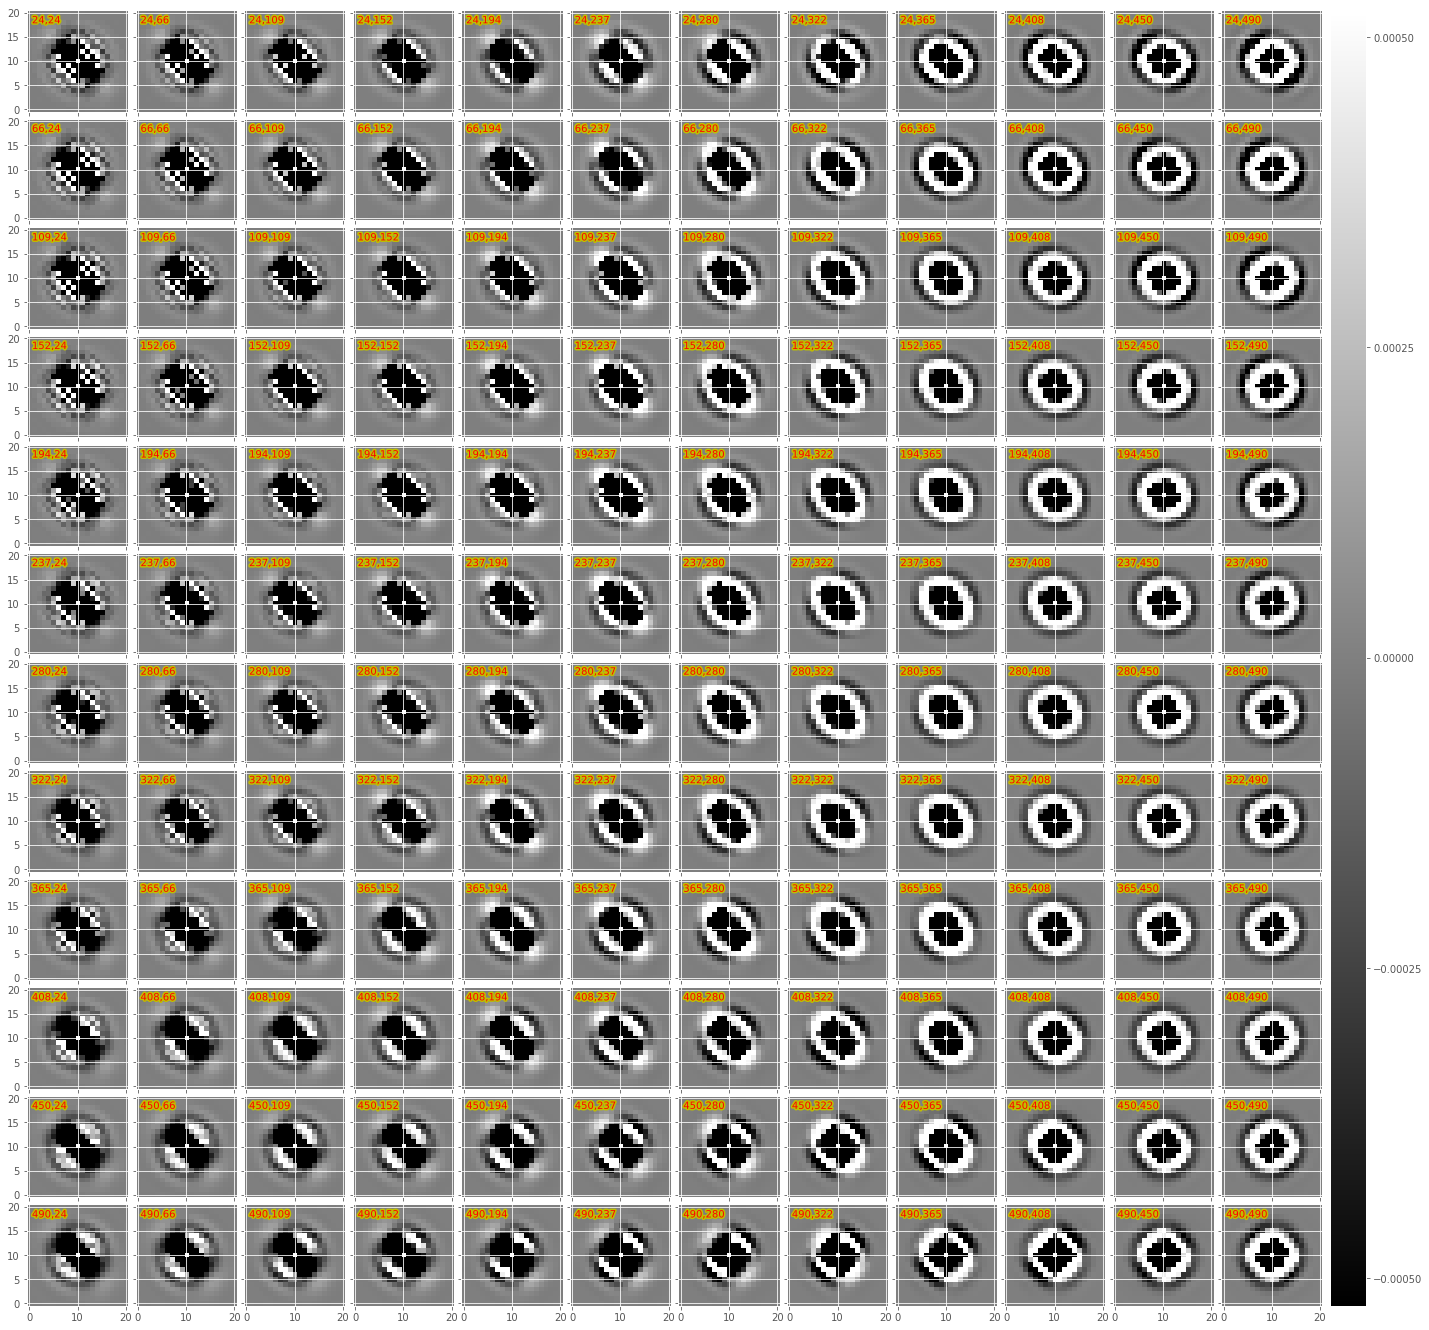

In [79]:
dcks = [res.decorrelationKernel for res in results]
dit.plotImageGrid(dcks, titles=titles)

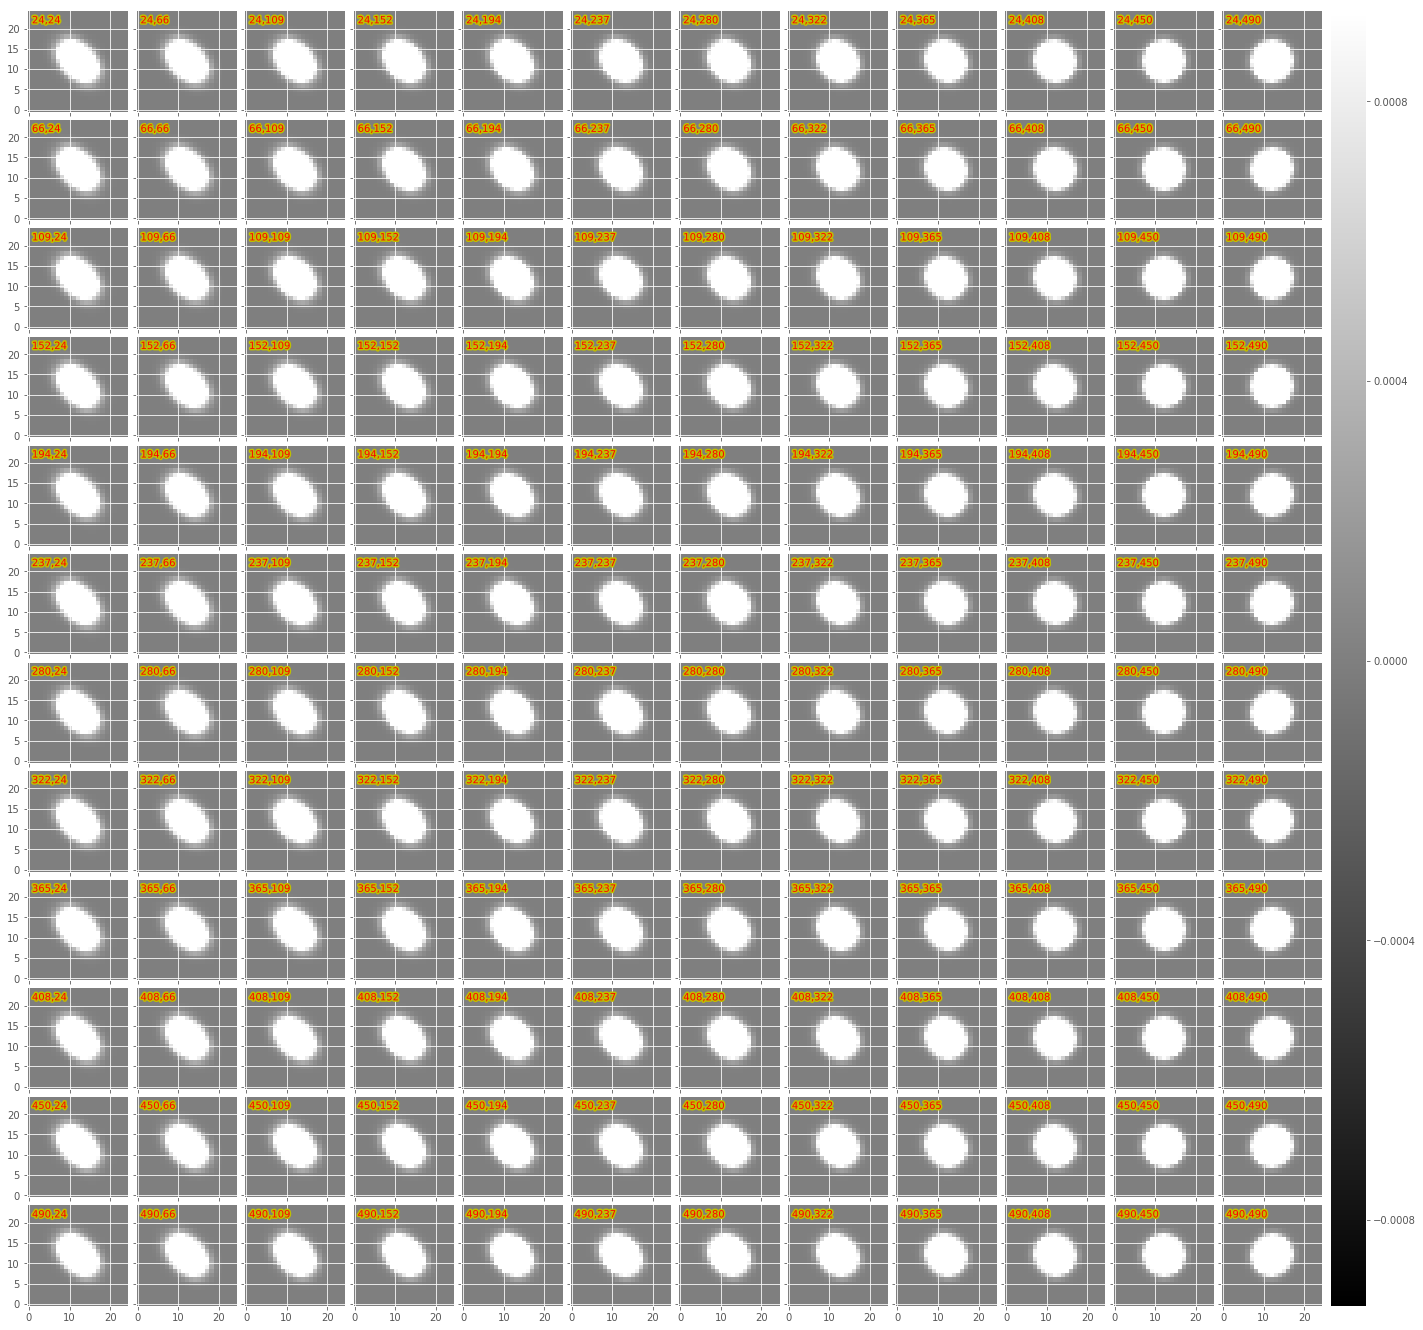

In [80]:
inpPsfs = [testObj.variablePsf.getImage(c[0], c[1]) for c in centers]
dit.plotImageGrid(inpPsfs, titles=titles)

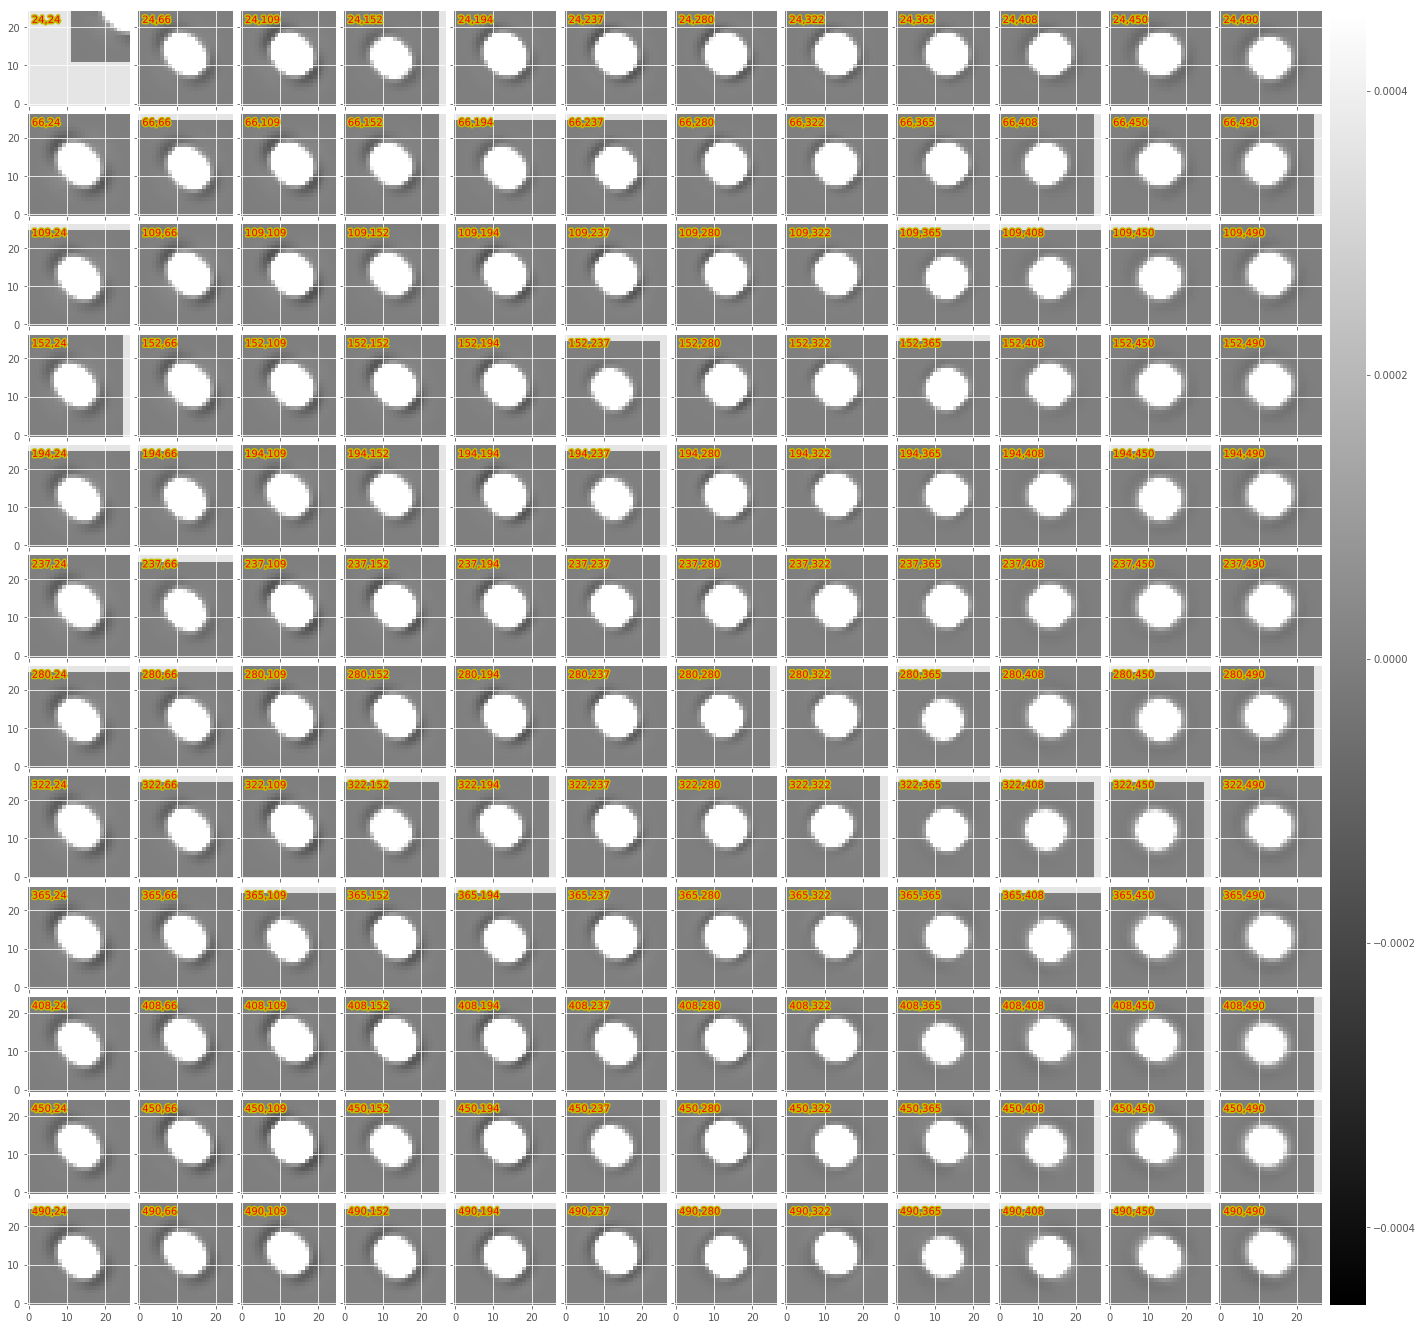

In [82]:
centers = [boxCenter(res.subExposure.getBBox()) for res in results]
psfs2 = [newExpB.getPsf().computeImage(afwGeom.Point2D(c[0], c[1])) for c in centers]
titles = ['%.0f,%.0f' % (c[0], c[1]) for c in centers]
dit.plotImageGrid(psfs2, titles=titles)

In [ ]:
def fixPsf(psf):
    if psf.shape[0] < psf.shape[1]:  # sometimes CoaddPsf does this.
        psf = np.pad(psf, ((1, 1), (0, 0)), mode='constant')
    elif psf.shape[0] > psf.shape[1]:
        psf = np.pad(psf, ((0, 0), (1, 1)), mode='constant')
    return psf

def diffPsf(psf1, psf2):
    psf1 = fixPsf(psf1.getArray())
    psf2 = fixPsf(psf2.getArray())
    if psf1.shape[0] < psf2.shape[0]:
        psf1 = np.pad(psf1, ((1, 1), (1, 1)), mode='constant')
    elif psf2.shape[0] < psf1.shape[0]:
        psf1 = np.pad(psf1, ((1, 1), (1, 1)), mode='constant')

#print [psf.getArray().shape for psf in psfs]
#print [fixPsf(psf.getArray()).shape for psf in psfs2]
psfDiffs = [diffPsf(psf, psf2) for psf,psf2 in zip(psfs, psfs2)]
dit.plotImageGrid(psfDiffs, titles=titles)

Let's try making a CoaddPsf, following the example in `meas_algorithms/tests/testCoaddPsf.py`

In [51]:
import lsst.afw.table as afwTable
import lsst.afw.coord as afwCoord

schema = afwTable.ExposureTable.makeMinimalSchema()
schema.addField("customweightname", type="D", doc="Coadd weight")
mycatalog = afwTable.ExposureCatalog(schema)

cd11 = 5.55555555e-05
cd12 = cd21 = 0.0
cd22 = 5.55555555e-05
crval1 = crval2 = 0.0
crpix = afwGeom.PointD(1000, 1000)
crval = afwCoord.Coord(afwGeom.Point2D(crval1, crval2))
wcsref = afwImage.makeWcs(crval, crpix, cd11, cd12, cd21, cd22)

# Each of the 9 has its peculiar Psf, Wcs, weight, and bounding box.
for i in range(1, 10, 1):
    record = mycatalog.getTable().makeRecord()
    psf = measAlg.DoubleGaussianPsf(100, 100, i, 1.00, 0.0)
    record.setPsf(psf)
    crpix = afwGeom.PointD(i*1000.0, i*1000.0)
    wcs = afwImage.makeWcs(crval, crpix, cd11, cd12, cd21, cd22)

    record.setWcs(wcs)
    record['customweightname'] = 1.0 * (i+1)
    record['id'] = i
    bbox = afwGeom.Box2I(afwGeom.Point2I(0, 0), afwGeom.Extent2I(i*1000, i*1000))
    record.setBBox(bbox)
    mycatalog.append(record)

# create the coaddpsf
mypsf = measAlg.CoaddPsf(mycatalog, wcsref, 'customweightname')

Now try it on our stuff...

In [52]:
def makePsf(mapperResults, exposure):
    import lsst.afw.table as afwTable

    schema = afwTable.ExposureTable.makeMinimalSchema()
    schema.addField("weight", type="D", doc="Coadd weight")
    mycatalog = afwTable.ExposureCatalog(schema)

    for i, res in enumerate(mapperResults):
        subExp = res.subExposure
        record = mycatalog.getTable().makeRecord()
        record.setPsf(subExp.getPsf())
        record.setWcs(subExp.getWcs())
        record.setBBox(subExp.getBBox())
        record['weight'] = 1.0
        record['id'] = i
        mycatalog.append(record)

    # create the coaddpsf
    psf = measAlg.CoaddPsf(mycatalog, exposure.getWcs(), 'weight')
    return psf

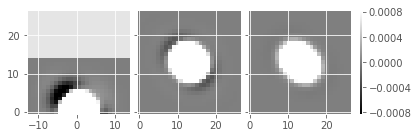

In [78]:
mypsf = makePsf(results, exposure)
dit.plotImageGrid((mypsf.computeKernelImage(afwGeom.Point2D(24, 24)),
                   mypsf.computeKernelImage(afwGeom.Point2D(24,237)),
                   mypsf.computeKernelImage(afwGeom.Point2D(24,480)),))

OK, after adding the `_constructPsf` method to `ImageReducerSubTask`:

In [31]:
import testPsfexPsfEDITED as tpp

exposure2 = testObj.im2.asAfwExposure()
#res = dit.tasks.doMeasurePsf(exposure2) #, psfMeasureConfig=config)
#psf = res.psf
obj = tpp.SpatialModelPsfTestCase() # removed superclass unittest.TestCase
obj.setExposure(exposure2)
obj.setUp()
obj.testPsfexDeterminer()
psf = obj.exposure.getPsf()
exposure2.setPsf(psf)

template2 = testObj.im1.asAfwExposure()
#res = dit.tasks.doMeasurePsf(template2) #, psfMeasureConfig=config)
#psf = res.psf
obj = tpp.SpatialModelPsfTestCase() # removed superclass unittest.TestCase
obj.setExposure(template2)
obj.setUp()
obj.testPsfexDeterminer()
psf = obj.exposure.getPsf()
template2.setPsf(psf)

539
538


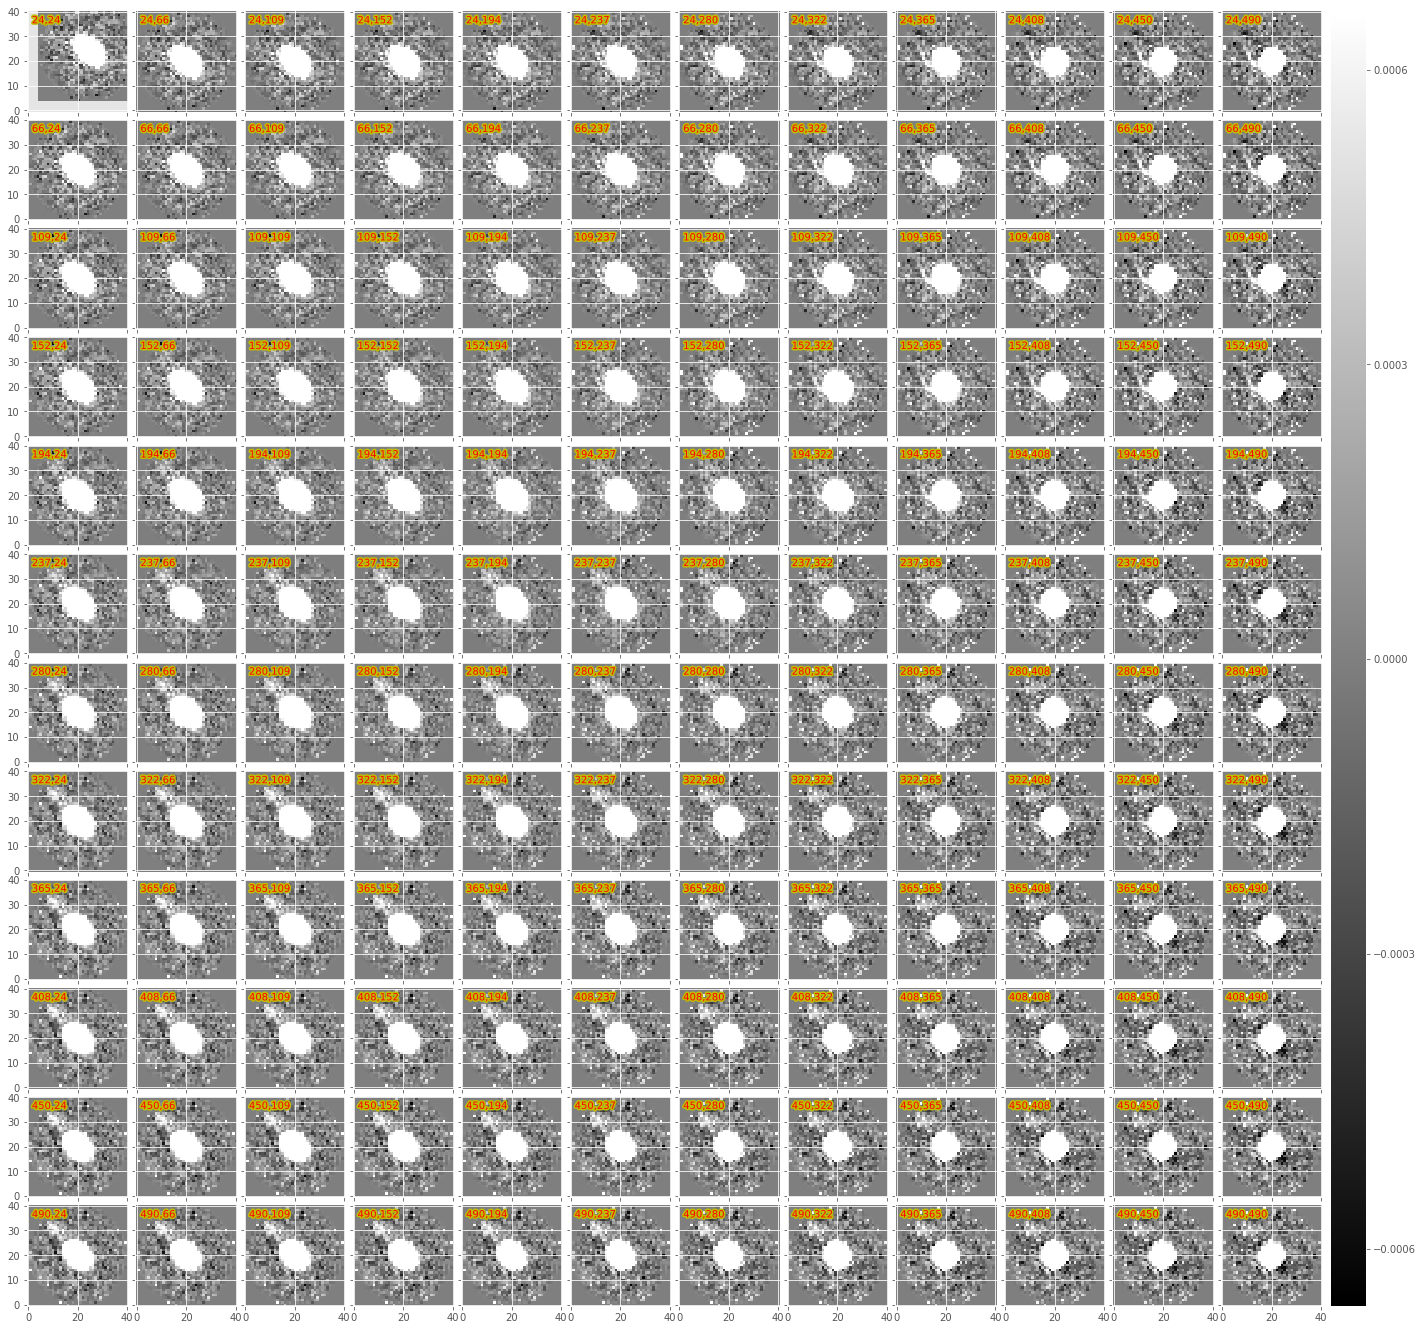

In [33]:
psfs2b = [exposure2.getPsf().computeImage(afwGeom.Point2D(c[0], c[1])) for c in centers]
titles = ['%.0f,%.0f' % (c[0], c[1]) for c in centers]
dit.plotImageGrid(psfs2b, titles=titles)

In [35]:
ALres = dit.tasks.doAlInStack(template2, exposure2, doWarping=False, doDecorr=True, doPreConv=False,
            spatialBackgroundOrder=0, spatialKernelOrder=2)

In [36]:
newExpC = task.run(ALres.subtractedExposure, template=template2, science=exposure2,
                  alTaskResult=ALres, forceEvenSized=True).exposure

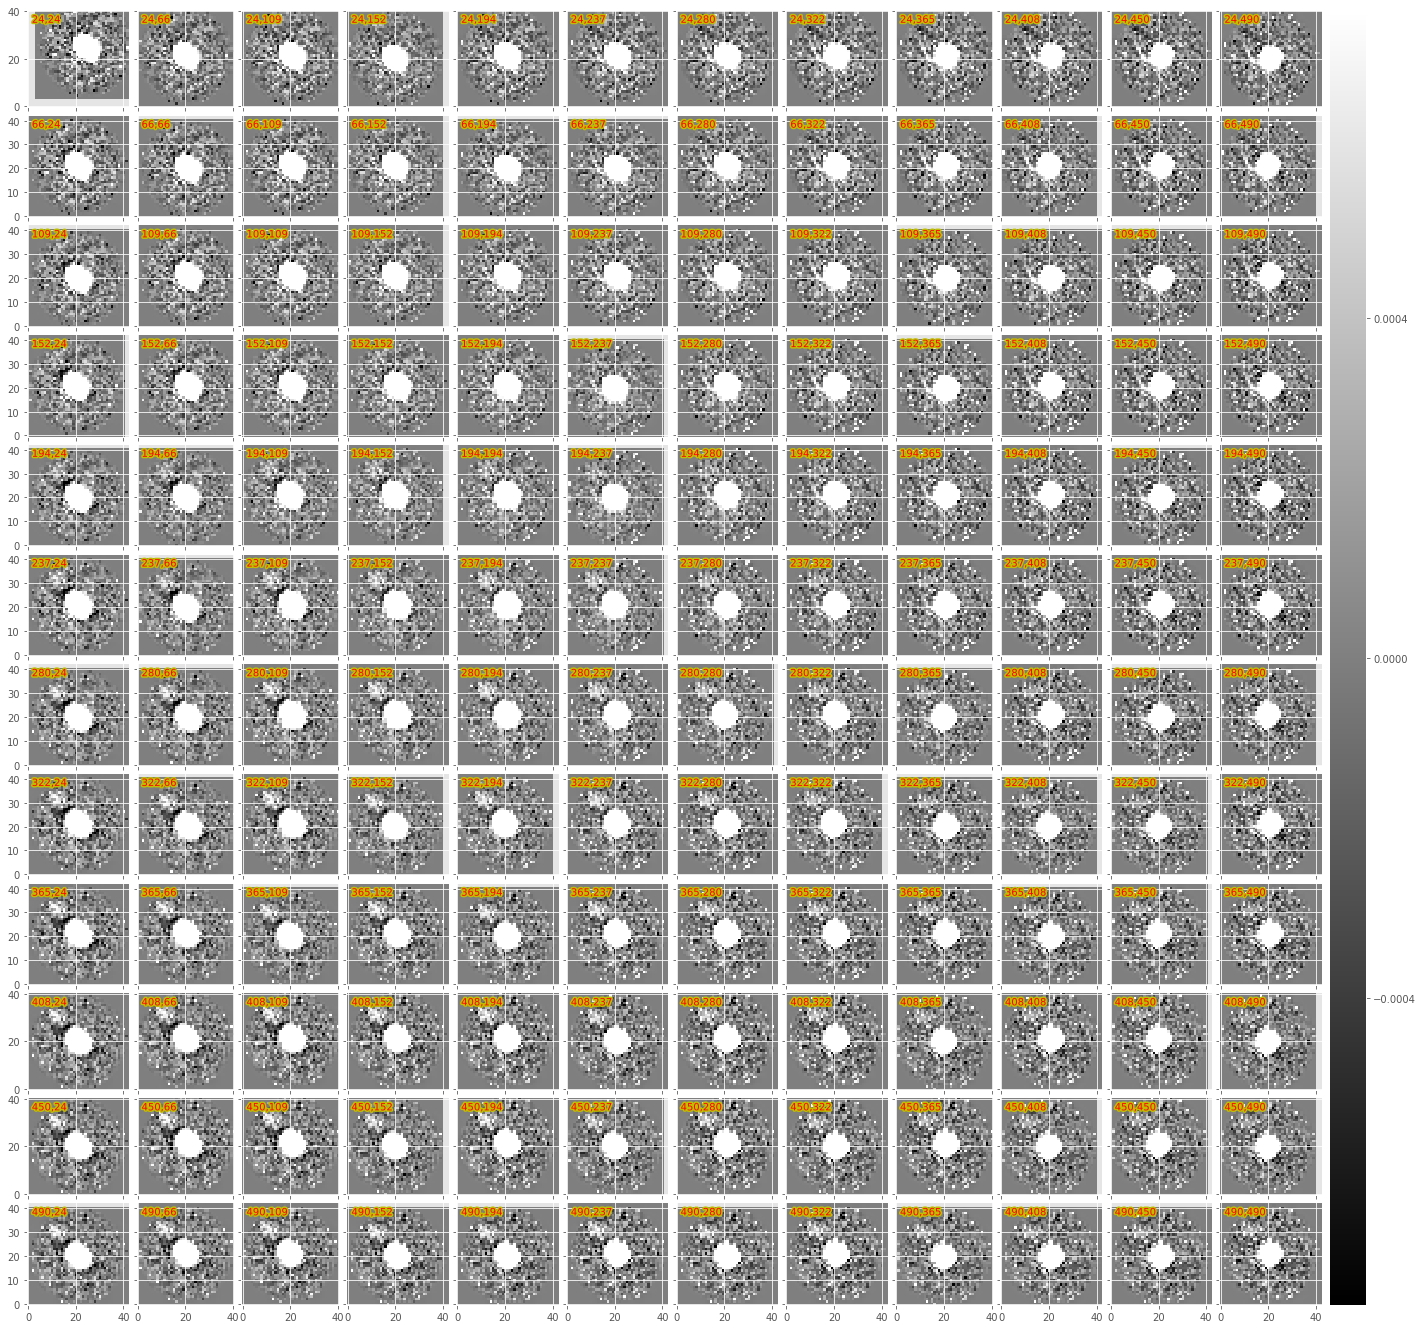

In [37]:
psfs3 = [newExpC.getPsf().computeImage(afwGeom.Point2D(c[0], c[1])) for c in centers]
titles = ['%.0f,%.0f' % (c[0], c[1]) for c in centers]
dit.plotImageGrid(psfs3, titles=titles)

In [49]:
psfs3a = [newExpC.getPsf().computeKernelImage(afwGeom.Point2D(c[0], c[1])) for c in centers]
[p.getDimensions() for p in psfs3][0:5]

[Extent2I(43, 43),
 Extent2I(41, 43),
 Extent2I(43, 43),
 Extent2I(41, 41),
 Extent2I(43, 43)]

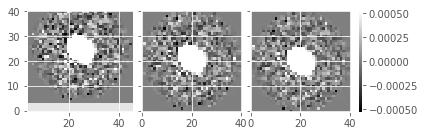

In [46]:
dit.plotImageGrid((psfs3a[0], psfs3a[1], psfs3a[3]))

In [52]:
print psfs3a[0].getDimensions(), psfs3a[0].getBBox(), dit.psf.computeMoments(psfs3a[0].getArray())
print psfs3a[1].getDimensions(), psfs3a[1].getBBox(), dit.psf.computeMoments(psfs3a[1].getArray())
print psfs3a[3].getDimensions(), psfs3a[3].getBBox(), dit.psf.computeMoments(psfs3a[3].getArray())

(43, 43) Box2I((-21, -21), (21, 21)) (-0.05294033300812942, 0.0026133617018149163)
(41, 43) Box2I((-20, -21), (20, 21)) (-0.057449008775235642, -0.0011054457116085308)
(41, 41) Box2I((-20, -20), (20, 20)) (-0.06669625345903217, -0.0087312469039510024)


In [60]:
psf = newExpC.getPsf()
psf.recenterKernelImage?